
# Vector Representations
## *Data Science Unit 4.1.2*

Michael Luo

2023/02/22

## 0.1 Get `spacy`

In [1]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.0 which is incompatible.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-23 05:59:11.636012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enab

##0.2 Restart Runtime

## 0.3 Imports

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [2]:
!git clone https://github.com/michael-s-luo/DS4.1_Natural-Language-Processing.git


Cloning into 'DS4.1_Natural-Language-Processing'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 396 (delta 12), reused 377 (delta 5), pack-reused 0
Receiving objects: 100% (396/396), 19.29 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist" 

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar. 
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [66]:
data_path = "/content/DS4.1_Natural-Language-Processing/module2-vector-representations/data/job_listings.csv"
df = pd.read_csv(data_path)

In [67]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [68]:
df['description'][0]

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need! 
* Don't spend more time than it takes to figure out how to remove html tags! 


In [75]:
from pandas.io.formats.format import TextAdjustment
def remove_html(text):
    """
    Extract text from html boiler plate code. 
    Converts bytes dtype into str dtype
    
    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/
    
    Parameters
    ----------
    text: string or object 
        contains text data that we want to clean
    
    Returns 
    -------
    text: str 
        cleaned text data ready for vectorization
    """
    
    # create soup object 
    soup = BeautifulSoup(text, 'html.parser')
    
    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string 
    #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    text = eval(soup.get_text())
    
    # if text is a byte data type, then convert to string 
    if isinstance(text, bytes):
        
        # convert byte data type into str
        text = text.decode("UTF-8")
        
    
    # use regex to clean your text data
    ###BEGIN SOLUTION
    import re
    pat = r"[^a-zA-z]"
    text = re.sub(pat, " ", text)
    ###END SOLUTION
    
    # case normalize and strip extra white spaces on the far left and right hand side
    return text.lower().strip()

In [76]:
df["clean_text"] = df["description"].apply(remove_html)
# would this work? df["clean_text"] = df.description.apply(remove_html)

## 2) Use Spacy to tokenize the listings 
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [78]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text. 
    Token filters are used to exclude low quality tokens.
    
    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token
    
    Input
    ----------
    text: string
        raw text document that needs to be tokenized
        
    Returns
    -------
    tokens: list of strings
    """

    doc = nlp(text)

    tokens = []
    for token in doc:
      if not(token.is_punct or token.is_stop or token.lemma_.strip()=="" or len(token.lemma_)==1):
        tokens.append(token.lemma_)

    return tokens


### Apply our tokenizer function via `pandas.apply()`

In [79]:
df["lemmas"] = df.clean_text.apply(tokenizer)

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function. 

0      job requirements  conceptual understanding in ...
1      job description  as a data scientist    you wi...
2      as a data scientist you will be working on con...
3      a monthcontractunder the general supervision o...
4      location  usa   multiple locations    years of...
                             ...                        
421    about us  want to be part of a fantastic and f...
422    internshipat uber  we ignite opportunity by se...
423    a yeara million people a year die in car colli...
424    senior data scientist job description  about u...
425    cerner intelligence is a new  innovative organ...
Name: clean_text, Length: 426, dtype: object

In [107]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
vect = CountVectorizer(tokenizer=tokenizer, min_df=0.01)
dtm_tf = vect.fit_transform(df['clean_text']) #sparse format
dtm_tf = pd.DataFrame(data=dtm_tf.todense(), columns=vect.get_feature_names_out())
###END SOLUTION

In [108]:
dtm_tf

,aa,ab,ability,able,abstract,academic,accelerate,accept,access,accessible,...,world,worldwide,worth,wrangle,write,writing,www,year,yes,york
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,2,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,5,0,1
422,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,0,0,1,0,0
424,0,0,0,2,0,0,2,0,0,0,...,1,0,0,0,0,0,0,1,0,0


## 4) Visualize the most common word counts in a barplot

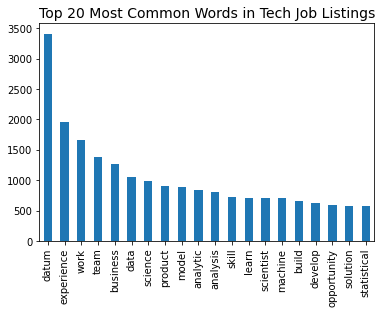

In [112]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tf.sum(axis=0).sort_values(ascending=False).head(20)

plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
plt.grid()
sorted_terms.plot.bar()
###END SOLUTION

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object


In [113]:
###BEGIN SOLUTION
tfidf_vect = TfidfVectorizer(tokenizer=tokenizer)

dtm_tfidf = tfidf_vect.fit_transform(df['clean_text'])
###END SOLUTION

In [114]:
dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tfidf_vect.get_feature_names_out())
dtm_tfidf

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.094546,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.021572,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.070503,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.114687,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.029659,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.105143,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.000000,0.067331,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

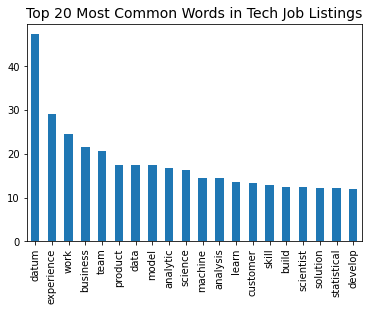

In [115]:
###BEGIN SOLUTION
top_n = 20
# sum the tf-idf in each column of the dtm_tfidf data frame and then sort in descending order
sorted_terms = dtm_tfidf.sum(axis=0).sort_values(ascending=False).head(20)

plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
plt.grid()
sorted_terms.plot.bar()
###END SOLUTION

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [116]:
ideal_ds_job_query=["Pharmacy and Healthcare Data Analyst Scientist Machine Learning Engineer Experience in Pharmacy PharmD Medicare Hospital Clinical"]

In [137]:
# vectorize your ideal job description using your fitted tfidf vectorizer 
ideal_job_vector = tfidf_vect.transform(ideal_ds_job_query)

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
# YOUR CODE HERE#
nn = NearestNeighbors()
nn.fit(dtm_tfidf)

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)

print(n_dist)
print(n_ind)

# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
for i in n_ind[0]:
  print(df['clean_text'].iloc[i])



[[1.2462345  1.27824112 1.30997168 1.31590097 1.31590097]]
[[213 150 201 167  81]]
houston methodist  hm  is looking for passionate data scientists to join the center for outcomes research  cor  to lead and develop informatics initiatives that transform healthcare via data science and informatics  the goal of the hm cor informatics initiative is to benefit patients and society as a whole by utilizing the skills and tools of data science to model patient populations clinically and economically within the context of the patient  the health care and hospital systems so that we can optimize business and clinical operations  improve patient care  reduce costs and position hm to more effectively address population health and other strategic health care needs into the future  the responsibility of the data scientist is to address the best uses of data science and informatics resources for hm clinical and business operations and patient care  including the organization s needs to assess and un

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
